In [16]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from collections import defaultdict
import torchvision.transforms as transforms
from PIL import Image
from torcheval.metrics.functional import multiclass_f1_score
from tqdm import tqdm

from config import *
from dataset import *
from model import *
from utils import *

In [17]:
set_seed(42)
device = get_device()
model = load_pretrained_model()
model = load_model(model)
model.to(device)

target_layers = [model.layer1[-1], model.layer2[-1], model.layer4[-1], model.layer4[-1]]

Model loaded


In [18]:
predictions = pd.read_csv(f"{args.checkpoint}/predictions.csv")
transform = transforms.Compose([transforms.Resize((150, 150)), 
                                transforms.ToTensor(), 
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
sample_breed = []
# Filter and sample correctly predicted examples for each breed
for breed in range(args.num_classes): 
    correct_predictions = predictions[(predictions["label"] == breed) & (predictions["prediction"] == breed)]
    sample_row = correct_predictions.sample(n=1)
    image = transform(Image.open(sample_row["path"].values[0]))
    image = image.unsqueeze(0)
    label = sample_row["label"].values[0]
    prediction = sample_row["prediction"].values[0]
    sample_breed.append((image, label, prediction))  


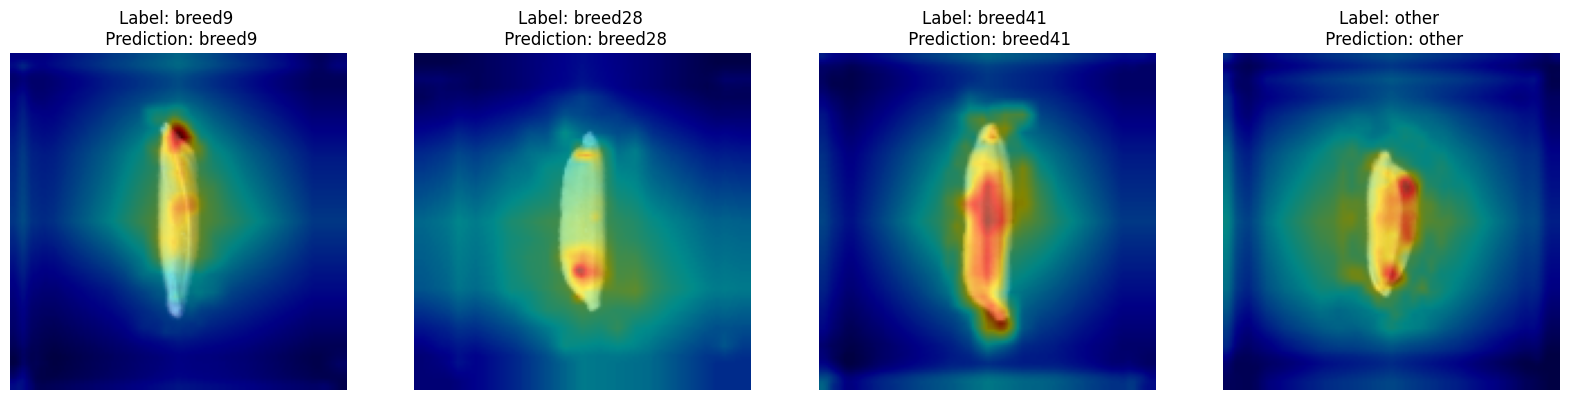

In [26]:
labels_dict = {0:"breed9", 1:"breed28", 2:"breed41", 3:"other"}
cam = GradCAM(model=model, target_layers=target_layers)
plt.figure(figsize=(20, 20))
for i, (image, label, prediction) in enumerate(sample_breed):
    grayscale_cam = cam(input_tensor=image)
    rgb_img = (image * 0.5 + 0.5).clip(0, 1).squeeze(0).permute(1,2,0).cpu().numpy()
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True) # Overlay 
    plt.subplot(1, 4, i+1)
    plt.imshow(visualization)
    plt.axis('off')
    plt.title(f"Label: {labels_dict[label]} \n Prediction: {labels_dict[label]}")

plt.savefig(f'{args.checkpoint}/GradCam.png', format='png', dpi=300)